In [3]:
from IPython.display import Image

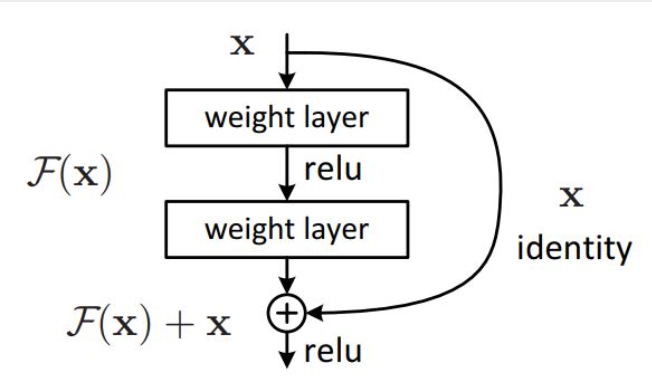

In [4]:
Image('./resNet.png')

Skip Connection을 적용한 Residual block의 모습입니다. 


이렇게 입력을 출력에 더하여 다음 Layer의 입력으로 사용하게 되면 역전파시 미분 값이 적어도 1이상의 값이 나와 기울기가 0으로 수렴하는 현상을 최소화했습니다.

ResNet에서는 두 종류의 Residual block을 사용합니다. Residual block을 쌓아 굉장히 깊은 층의 모델을 만들어냅니다.

Residual block : Feature map의 크기를 절반으로 줄이는 대신 Feature map의 Dimension을 2배로 늘리는 block입니다. Dimension을 맞추기 위해 1 x 1 Convolution을 사용한 block입니다. 이를 Projection Shortcut Connection 이라 합니다.

Identity block : 입력과 출력의 Dimension이 같은 경우에 사용합니다.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import add, Input,Dense,Activation, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D, ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model


# 입력과 출력의 Dimension이 같은 경우 사용합니다.
def identity_block(input_tensor, kernel_size, filters):
    
    filters1, filters2, filters3 = filters
    
    x = Conv2D(filters1, (1, 1))(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1))(x)
    x = BatchNormalization()(x)
    
    '''
    지시사항 1번
    아래 내용을 채워 identity_block()을 완성하세요.
    '''
    # 입력(x) : input_tensor와 F(x) : x를 더해줍니다.
    # TODO : add()와 Activation() 메서드를 사용해서 relu(F(x) + x) 의 형태로 만들어보세요. 
    x = add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def residual_block(input_tensor, kernel_size, filters, strides=(2, 2)):
    filters1 , filters2 , filters3 = filters
    
    # 입력 Feature Map의 Size를 1/2로 줄이는 대신 Feature map의 Dimension을 2배로 늘려줍니다.
    x = Conv2D(filters1, (1, 1), strides=strides)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1))(x)
    x = BatchNormalization()(x)
    
    
    '''
    지시사항 2번
    아래 내용을 채워 residual_block()을 완성하세요.
    '''
    # TODO : Projection Shortcut Connection을 구현해보세요.
    # 1 x 1 Convolution 연산을 수행하여 Dimension을 2배로 증가시키고
    # 입력 Feature map의 size를 1/2로 축소시켜보세요.
    shortcut = Conv2D(filters3, (1, 1), strides=strides)(input_tensor)
    shortcut = BatchNormalization()(shortcut)

    # F(x) : x와 Shortcut Connection : shortcut을 더해줍니다.
    # TODO : add()와 Activation() 메서드를 사용해서 relu(F(x) + shortcut) 의 형태로 만들어보세요.
    x = add([x, shortcut])
    x = Activation('relu')(x)
    return x


def ResNet50():
    # 입력 이미지의 Shape을 정해줍니다.
    shape = (224,224,3)
    inputs = Input(shape)
    
    # 입력 영상의 크기를 줄이기 위한 Conv & Max-pooling
    x = ZeroPadding2D((3, 3))(inputs)
    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)
    
    # 첫 번째 Residual Block (입력 영상 Size 2배 축소 / Dimension 2배 증가)
    x = residual_block(x, 3, [64, 64, 256], strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256])
    x = identity_block(x, 3, [64, 64, 256])
    
    
    # 두 번째 Residual Block (입력 영상 Size 2배 축소 / Dimension 2배 증가)
    x = residual_block(x, 3, [128, 128, 512])
    x = identity_block(x, 3, [128, 128, 512])
    x = identity_block(x, 3, [128, 128, 512])
    x = identity_block(x, 3, [128, 128, 512])
    
    # 세 번째 Residual Block (입력 영상 Size 2배 축소 / Dimension 2배 증가)
    x = residual_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])
    x = identity_block(x, 3, [256, 256, 1024])
    
    # 네 번째 Residual Block (입력 영상 Size 2배 축소 / Dimension 2배 증가)
    x = residual_block(x, 3, [512, 512, 2048])
    x = identity_block(x, 3, [512, 512, 2048])
    x = identity_block(x, 3, [512, 512, 2048])

    # 마지막단에서 FC layer를 쓰지 않고 단순히 Averaging 합니다.
    x = AveragePooling2D((7, 7))(x)
    # x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)
    # 1000개의 Class 구분
    x = Dense(1000, activation='softmax')(x)
    
    # 모델 구성
    model = Model(inputs, x)
    return model

model = ResNet50()
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
______________________________________________________________________________________________